In [2]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def pic_show(pic_tensor: torch.TensorType, mean: list, std: list):
    """
    图片批量展示(包含反归一化操作)
    """
    pic_tensor = reve_norm(pic_tensor, mean, std)   # 反归一化操作
    pic_tensor = pic_tensor.detach().cpu()
    batch_pic = make_grid(pic_tensor,  nrow=20, padding=0)
    batch_pic = np.transpose(batch_pic, (1, 2, 0))
    plt.figure(dpi=200)
    plt.imshow(batch_pic)
    plt.axis("off")

# 反归一化：img * std + mean


def reve_norm(pic_tensor: torch.TensorType, mean: list, std: list):
    for channel in range(pic_tensor.shape[1]):
        pic_tensor[:, channel, :, :] = pic_tensor[:,
                                                  channel, :, :] * std[channel] + mean[channel]
    return pic_tensor


# 1. 导入数据集

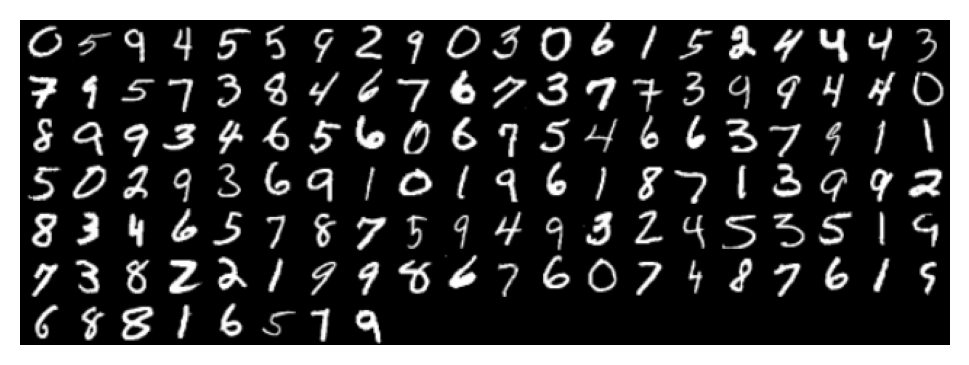

In [4]:
mean = [0.5]
std = [0.5]
trainset = MNIST("../data", train=True, download=True, transform=transforms.Compose(
    [
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]
))
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
train_demo = iter(trainloader)
train_demo, _ = next(train_demo)
pic_show(train_demo, mean, std)


In [5]:
_

tensor([0, 5, 9, 4, 5, 5, 9, 2, 9, 0, 3, 0, 6, 1, 5, 2, 4, 4, 4, 3, 7, 9, 5, 7,
        3, 8, 4, 6, 7, 6, 7, 3, 7, 7, 3, 9, 9, 4, 4, 0, 8, 9, 9, 3, 4, 6, 5, 6,
        0, 6, 7, 5, 4, 6, 6, 3, 7, 9, 1, 1, 5, 0, 2, 9, 3, 6, 9, 1, 0, 1, 9, 6,
        1, 8, 7, 1, 3, 9, 9, 2, 8, 3, 4, 6, 5, 7, 8, 7, 5, 9, 4, 9, 3, 2, 4, 5,
        3, 5, 1, 9, 7, 3, 8, 2, 2, 1, 9, 9, 8, 6, 7, 6, 0, 7, 4, 8, 7, 6, 1, 9,
        6, 8, 8, 1, 6, 5, 7, 9])

# 2 确定超参数的值
$$
\begin{aligned}
x_t &= \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} z \\
\alpha_t &= 1 - \beta_t \\
\bar{\alpha}_T &= \alpha_1 * \alpha_2 * \cdots  * \alpha_T
\end{aligned}
$$
alphas_prod     : ${\bar{\alpha}_1, \bar{\alpha}_2, \cdots, \bar{\alpha}_T}$  
alphas_prod_p   : ${\bar{\alpha}_0, \bar{\alpha}_1, \cdots, \bar{\alpha}_{T-1}}$  
alphas_bar_sqrt : ${\sqrt{\bar{\alpha}_1}, \sqrt{\bar{\alpha}_2}, \cdots, \sqrt{\bar{\alpha}_{T}}}$  
one_minus_alphas_bars_log : $\ln{(1 - \bar{\alpha}_1)}, \ln{(1 - \bar{\alpha}_2)}, \cdots, \ln{(1 - \bar{\alpha}_T)}$  
one_minus_alphas_bars_sqrt: $\sqrt{1 - \bar{\alpha}_1}, \sqrt{1 - \bar{\alpha}_2}, \cdots, \sqrt{1 - \bar{\alpha}_T}$

In [6]:
num_step = 1000        # 扩散步骤进行1000步
# 制定每一步的beta
betas = torch.linspace(-6, 6, num_step)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5   # betas的值一般比较小
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bars_log = torch.log(1 - alphas_prod)
one_minus_alphas_bars_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bars_log.shape == one_minus_alphas_bars_sqrt.shape
print(f"all the same shape:{alphas.shape}")


all the same shape:torch.Size([1000])


# 3 确定扩散过程任意时刻的任意时刻的采样值
$$
x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\bar{z}_t
$$

In [7]:
def q_x(x_0, t, alphas_bar_sqrt: torch.TensorType, one_minus_alphas_bars_sqrt: torch.TensorType):
    """
        基于 x_0 得到任意时刻的t的 x_t
    """
    noise = torch.randn_like(x_0, device=x_0.device)
    return alphas_bar_sqrt[t] * x_0 + one_minus_alphas_bars_sqrt[t] * noise


# 4 显示原始数据分布加噪1000步之后的效果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


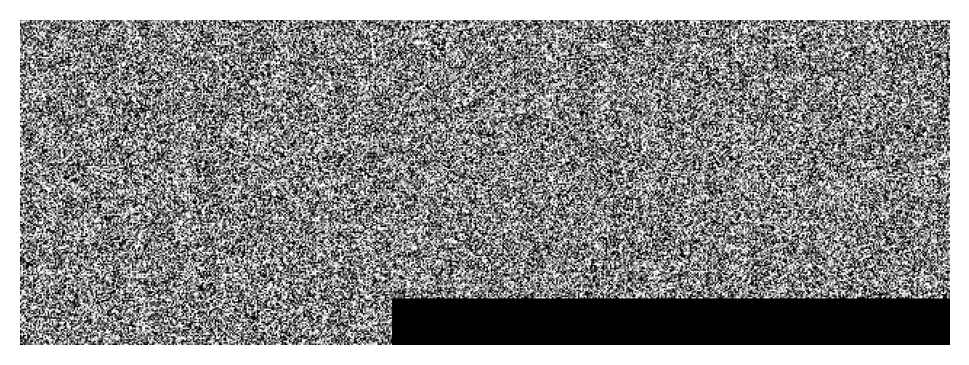

In [9]:
t = 999
q_i = q_x(train_demo, t, alphas_bar_sqrt, one_minus_alphas_bars_sqrt)
pic_show(q_i, mean, std)


# 5 逆扩散过程

In [24]:
import torch.nn as nn
# 带有时间嵌入的Unet
class UNetModel(nn.Module):
    def __init__(
        self, in_channels, model_channels, out_channels, num_res_blocks,
        attention_resolutions, dropout=0, channel_mult=(1, 2, 4, 8),
        conv_resample=True, dims=2, num_classes=None, use_checkpoint=False,
        num_heads=1, num_heads_upsample=-1, use_scale_shift_norm=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.num_heads = num_heads
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        self.input_blocks = nn.ModuleList(
            [
                TimestepEmbedSequential(
                    conv_nd(dims, in_channels, model_channels, 3, padding=1)
                )
            ]
        )
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=mult * model_channels,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch, use_checkpoint=use_checkpoint, num_heads=num_heads
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(
                    TimestepEmbedSequential(Downsample(ch, conv_resample, dims=dims))
                )
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(ch, use_checkpoint=use_checkpoint, num_heads=num_heads),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResBlock(
                        ch + input_block_chans.pop(),
                        time_embed_dim,
                        dropout,
                        out_channels=model_channels * mult,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                        )
                    )
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample, dims=dims))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            nn.GroupNorm32(32, ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, model_channels, out_channels, 3, padding=1)),
        )

    @property
    def inner_dtype(self):
        """
        Get the dtype used by the torso of the model.
        """
        return next(self.input_blocks.parameters()).dtype

    def forward(self, x, timesteps, y=None):
        """
        Apply the model to an input batch.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.inner_dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            cat_in = th.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        h = h.type(x.dtype)
        return self.out(h)

    def get_feature_vectors(self, x, timesteps, y=None):
        """
        Apply the model and return all of the intermediate tensors.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: a dict with the following keys:
                 - 'down': a list of hidden state tensors from downsampling.
                 - 'middle': the tensor of the output of the lowest-resolution
                             block in the model.
                 - 'up': a list of hidden state tensors from upsampling.
        """
        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)
        result = dict(down=[], up=[])
        h = x.type(self.inner_dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
            result["down"].append(h.type(x.dtype))
        h = self.middle_block(h, emb)
        result["middle"] = h.type(x.dtype)
        for module in self.output_blocks:
            cat_in = th.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
            result["up"].append(h.type(x.dtype))
        return result

# 6 编写误差函数
$$
L_{simple}(\theta) := \mathbb{E}_{t, x_0, \epsilon} [|| \epsilon - \epsilon_\theta(\sqrt{\bar{\alpha_t}}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon, t) ||]
$$ 

In [18]:
def diffusion_loss_fn(model: nn.Module, x_0: torch.TensorType, alphas_bar_sqrt: torch.TensorType,
                      one_minus_alphas_bar_sqrt: torch.TensorType, n_steps: int):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]
    device = x_0.device
    t = torch.randint(0, n_steps, size=(
        batch_size//2,), device=device)    # ????
    t = torch.cat([t, n_steps-1-t], dim=0)                  # ????
    t = t.unsqueeze(-1)
    epsilon = torch.randn_like(x_0, device=device)
    x = torch.einsum("ijkl, im->ijkl", x_0, alphas_bar_sqrt[t]) + \
        torch.einsum("ijkl, im->ijkl", epsilon, one_minus_alphas_bar_sqrt[t])
    output = model(x, t.squeeze(-1))
    return (epsilon - output).square().mean()


# 7 逆扩散采样函数(inference过程)
$$
\mu_\theta\left(x_t, t\right)=\frac{1}{\sqrt{a_t}}\left(x_t-\frac{\beta_t}{\sqrt{1-\bar{a}_t}} \epsilon_\theta\left(x_t, t\right)\right)\\
\Sigma_\theta(x_t, t) = \beta_t 
$$

In [12]:
def p_sample_loop(model: nn.Module, shape: tuple, num_step: int, betas: torch.TensorType,
                  one_minus_alphas_bars_sqrt: torch.TensorType, device="cuda"):
    """从x_T恢复x_{T-1}, x_{T-2}, ..., x_0"""
    cur_x = torch.randn(shape, device=device)
    x_seq = [cur_x]
    for i in reversed(range(num_step)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bars_sqrt)
        x_seq.append(cur_x)
    return x_seq


def p_sample(model: nn.Module, x: torch.TensorType, t: int, betas: torch.TensorType, one_minus_alphas_bars_sqrt: torch.TensorType):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t], device=x.device)
    coeff = betas[t] / one_minus_alphas_bars_sqrt[t]
    eps_theta = model(x, t)
    mean = (1 / (1 - betas[t])).sqrt() * (x - (coeff * eps_theta))
    z = torch.randn_like(x, device=x.device)
    sigma_t = betas[t].sqrt()
    sample = mean + sigma_t * z
    return (sample)


# 8 训练模型,并打印loss及中间的重构效果

In [22]:
seed = 1212
class EMA(nn.Module):
    """构建一个参数平滑器"""
    def __init__(self, mu=0.01) -> None:
        super().__init__()
        self.mu = mu
        self.shadow = {}
    
    def register(self, name, val):
        self.shadow[name] = val.clone()
    
    def __cal__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
betas = betas.to(device)
one_minus_alphas_bars_sqrt = one_minus_alphas_bars_sqrt.to(device)
print("Trainning model...")

batchsize = 128
dataloader = torch.utils.data.DataLoader(train_demo, batchsize, shuffle=True)
num_epoch = 4000
plt.rc('text', color='white')

model = MLPDiffusion(num_step).to(device)
optimer = torch.optim.Adam(model.parameters(), lr=1e-3)
for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x.to(device), alphas_bar_sqrt.to(device), one_minus_alphas_bars_sqrt.to(device), num_step)
        optimer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimer.step()
    
    if t % 100 == 0:   
        print(f"epoch:{t} || loss:{loss.item()}")
        x_seq = p_sample_loop(model, train_demo.shape, num_step, betas, one_minus_alphas_bars_sqrt,device=device)
        
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach().cpu()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolors="white")
            axs[i-1].set_axis_off()
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i * 10)+'})$')
                

Trainning model...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4096x32 and 2x128)

In [ ]:
torch.save(model, "diffusion_demo.pth")


# 使用训练过的模型进行推断

In [ ]:
device = torch.device("cpu")
model_trained = torch.load("diffusion_demo.pth").to(device)
x_seq = p_sample_loop(model_trained, dataset.shape, num_step,
                      betas, one_minus_alphas_bars_sqrt, device=device)


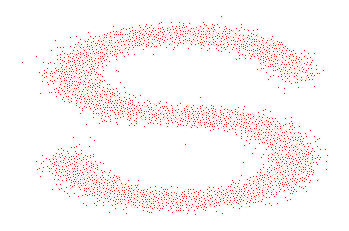

In [ ]:
import io
from PIL import Image
imgs = []

for i in range(100):
    plt.clf()       # 清除当前 figure 的所有axes，但是不关闭这个 window，所以能继续复用于其他的 plot
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:, 0],  q_i[:, 1], color='red', edgecolors="white", s=5)
    plt.axis("off")

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)

reverse = []
for i in range(1, 101):
    plt.clf()       # 清除当前 figure 的所有axes，但是不关闭这个 window，所以能继续复用于其他的 plot
    cur_x = x_seq[i].detach().cpu()
    plt.scatter(cur_x[:, 0],  cur_x[:, 1],
                color='red', edgecolors="white", s=5)
    plt.axis("off")

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)

imgs = imgs + reverse
imgs[0].save("diffusion.gif", format="GIF", append_images=imgs,
             save_all=True, duration=100, loop=0)
